In [1]:
%matplotlib inline 

import astropy.io.fits as fits
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
cd '../sirpol_flat/2017'

/Users/yas.nakajima/Library/Mobile Documents/com~apple~CloudDocs/sirpol_flat/2017


SIRPOLのフラットチェック。楠根君取得のデータ。2017年3月   
- 波長板角度0度　20170311（朝）、20170317（夕）  
- 波長板角度45度　20170315（夕・朝）  
- 波長板角度22.5度　20170312（夕）、20170319（夕・朝）  
- 波長板角度67.5度　20170316（夕・朝）  
- 波長板を回転させてのtwflat　20170321（朝）  

夕方に撮ったものは、気温が高いために象限の入れ替わりエラーが数回発生  
観測フィールドは全て同じもので撮っています（夕：twflat0300-3509、朝：twflat2125-3500）  

朝のものだけを抽出して、flatを作成した。 以下のディレクトリ。

In [3]:
ls

lpflat00/ lpflat22/ lpflat45/ lpflat67/


?twf00m.fits などが作成したフラットである。

In [4]:
ls lpflat00/

dlist            htwf00m.fits     jtwf00m.fits     ktwf00m.fits
hbackground.txt  jbackground.txt  kbackground.txt  mktwflist.param
hflatlist        jflatlist        kflatlist
hflatlist.0      jflatlist.0      kflatlist.0


何枚のペア(明るい - 暗い)が利用できたかは以下。 ! でunixコマンド利用可

In [5]:
! wc -l  lpflat00/?flatlist

       5 lpflat00/hflatlist
       8 lpflat00/jflatlist
      30 lpflat00/kflatlist
      43 total


In [6]:
! wc -l  lpflat22/?flatlist

       4 lpflat22/hflatlist
       6 lpflat22/jflatlist
      27 lpflat22/kflatlist
      37 total


In [7]:
! wc -l  lpflat45/?flatlist

       4 lpflat45/hflatlist
       7 lpflat45/jflatlist
      24 lpflat45/kflatlist
      35 total


In [8]:
! wc -l  lpflat67/?flatlist

       8 lpflat67/hflatlist
       6 lpflat67/jflatlist
      19 lpflat67/kflatlist
      33 total


(少なくとも神鳥論文では)H-bandが重要なので、H-bandでのペア枚数が一番多い67.5度のものと他の角度を比較する。 

In [9]:
def img_ratio(fits1, fits2):
    data1 = fits.getdata(fits1)
    data2 = fits.getdata(fits2)
    
    x = np.where(data2 < 0.01)  #  to avoid dividing by zero 
    data2[x] = 99999.
    
    return data1 / data2

In [10]:
def clipmed(img, lthresh, hthresh):
    # calculation of the median with 3-sigma clipping 
    
    cindex = np.where((img > lthresh) & (img < hthresh))
    cimg = img[cindex]
    if cimg.size < 5:
        return -99, -99

    med = np.median(cimg)
    for i in range(5):
        sigma = np.sqrt(np.sum((cimg - med)**2)/cimg.size)
        index = np.where(np.fabs(cimg - med) <= 3 * sigma)
        cimg = cimg[index]
        med = np.median(cimg)
        
    return med, sigma

In [11]:
def median_filter(img):
    mimg = np.zeros((64, 64))
    sigimg = np.zeros((64, 64))
    # 1024x1024 -> 64x64
    for i in range(0,64):
        for j in range(0,64):
            xz = 16 * i
            yz = 16 * j
            #mimg[i, j], sigimg[i, j] = clipmed(img[xz:xz+16, yz:yz+16], 0.1, 2)
            mimg[i, j], sigimg[i, j] = clipmed(img[xz:xz+16, yz:yz+16], 0.1, 2)
                        
    return mimg, sigimg

In [12]:
mycmap = cm.get_cmap('jet')
mycmap.set_under('w')
levels = np.arange(0.90, 1.1, 0.01)
lwarr = np.array([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2])

levels2 = np.arange(0.00, 0.10, 0.01)
lwarr2 = np.array([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2])


In [13]:
def show_scale_contour2(img):
    cimg, cimg2 = median_filter(img)
    print(np.median(cimg2))
    fig = plt.figure(figsize=(11,5))
    
    ax1 = plt.subplot(121)
    divider1 = make_axes_locatable(ax1)
    ax_cb1 = divider1.new_horizontal(size="3%", pad=0.05)        
    im1 = plt.imshow(img, cmap=mycmap, vmin=0.9, vmax=1.1, interpolation='nearest', origin='lower')
    plt.contour(cimg, levels, linewidths=lwarr, colors='k', extent=(0,1024, 0,1024))
    fig.add_axes(ax_cb1)
    plt.colorbar(im1, cmap=mycmap, cax=ax_cb1)
    
    ax2 = plt.subplot(122)
    
    divider2 = make_axes_locatable(ax2)
    ax_cb2 = divider2.new_horizontal(size="3%", pad=0.05)    
    im2 = plt.imshow(cimg2, cmap=mycmap, vmin=0.00, vmax=0.04, interpolation='nearest', origin='lower')
    #plt.contour(cimg2, levels2, linewidths=lwarr2, colors='k', extent=(0,64, 0,64))
    fig.add_axes(ax_cb2)
    plt.colorbar(im2, cmap=mycmap, cax=ax_cb2)
    
    plt.show()

In [14]:
jr00 = img_ratio('lpflat00/jtwf00m.fits', 'lpflat67/jtwf67m.fits')
hr00 = img_ratio('lpflat00/htwf00m.fits', 'lpflat67/htwf67m.fits')
kr00 = img_ratio('lpflat00/ktwf00m.fits', 'lpflat67/ktwf67m.fits')

0.0185266188144


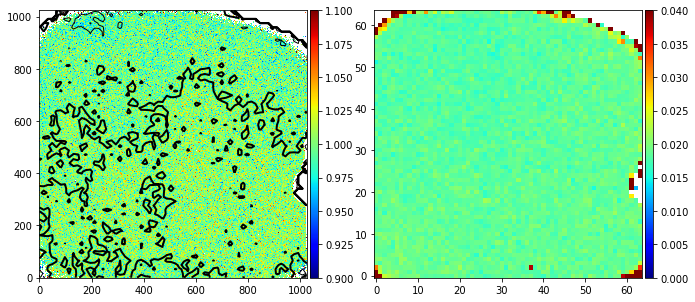

In [15]:
show_scale_contour2(jr00)

0.0233324152819


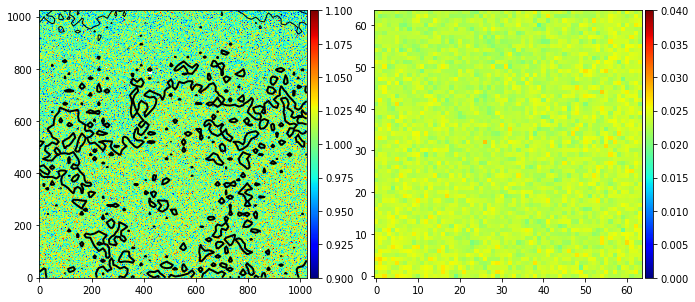

In [16]:
show_scale_contour2(hr00)

0.0105377245527


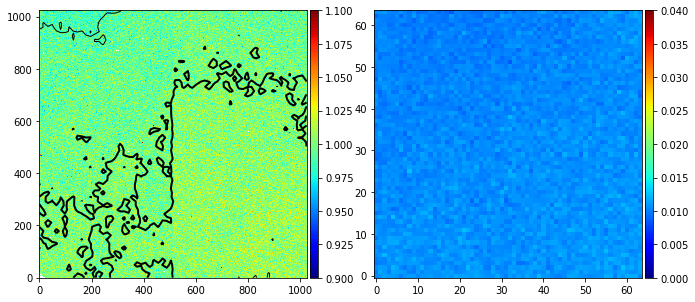

In [17]:
show_scale_contour2(kr00)

In [18]:
jr22 = img_ratio('lpflat22/jtwf22m.fits', 'lpflat67/jtwf67m.fits')
hr22 = img_ratio('lpflat22/htwf22m.fits', 'lpflat67/htwf67m.fits')
kr22 = img_ratio('lpflat22/ktwf22m.fits', 'lpflat67/ktwf67m.fits')

0.0190701263352


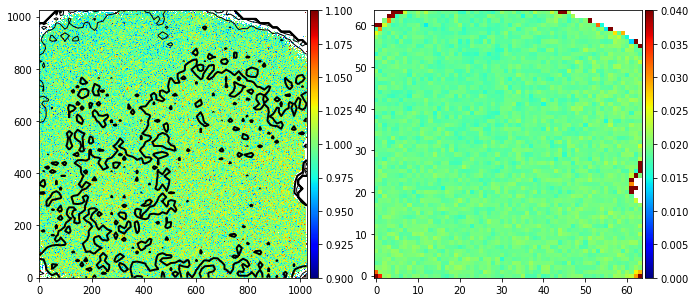

In [19]:
show_scale_contour2(jr22)

0.0227273971051


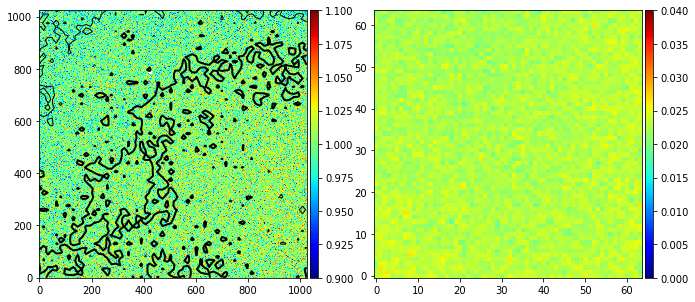

In [20]:
show_scale_contour2(hr22)

0.0107263635751


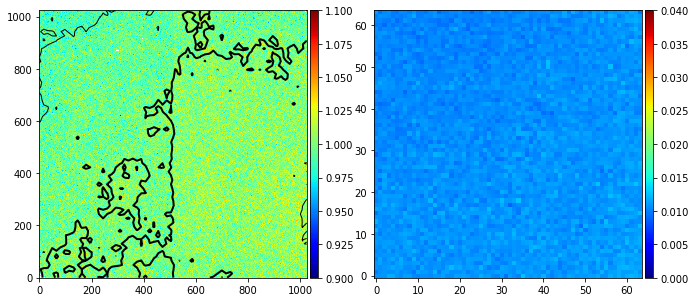

In [21]:
show_scale_contour2(kr22)

In [22]:
jr45 = img_ratio('lpflat45/jtwf45m.fits', 'lpflat67/jtwf67m.fits')
hr45 = img_ratio('lpflat45/htwf45m.fits', 'lpflat67/htwf67m.fits')
kr45 = img_ratio('lpflat45/ktwf45m.fits', 'lpflat67/ktwf67m.fits')

0.0193749622327


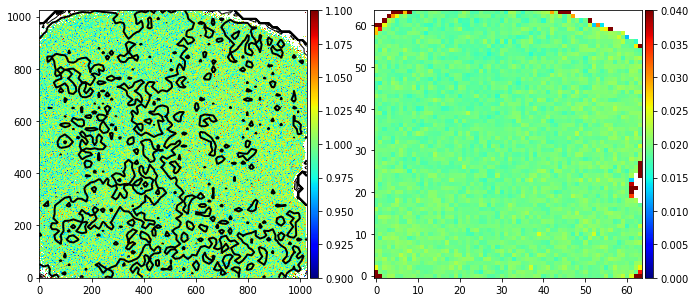

In [23]:
show_scale_contour2(jr45)

0.0222699216251


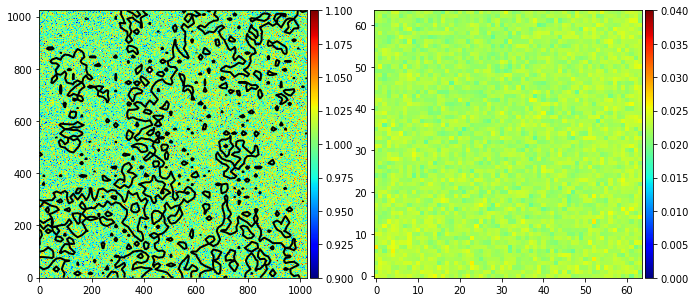

In [24]:
show_scale_contour2(hr45)

0.0104263611741


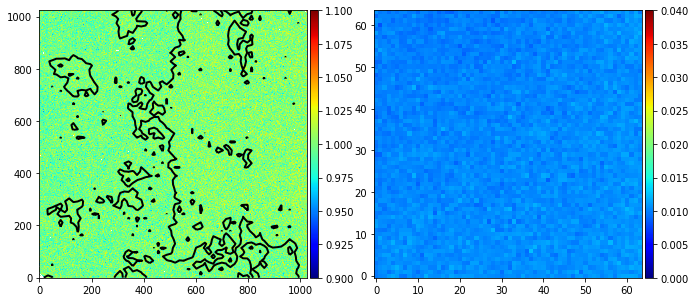

In [25]:
show_scale_contour2(kr45)